# Figures 5 & 6
In this notebook, we reproduce panels from Figures 5 and 6.

We first import the necessary packages, i.e. `NumPy`, `SciPy`, and `Matplotlib`.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import binned_statistic, linregress, norm
from scipy.linalg import lstsq
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple
from mpl_toolkits.axes_grid1 import make_axes_locatable

We also import a module called `stats_tools` which contains our own statistics functions that are specifically written for the synaptic data. This, in turn, requires `SciPy` and `Scikit-learn`.

In [2]:
from stats_tools import curate_data, slope_vs_dt, cv, cv_single

We define some layout settings for the plots and a few other auxiliary variables.

In [3]:
plt.rcParams.update({'pdf.fonttype': 42,
                     'pdf.use14corefonts': False,
                     'ps.useafm': False,
                     'figure.constrained_layout.use': True,
                     'figure.dpi': 150.,
                     'font.size': 7,
                     'figure.titlesize': 7,
                     'figure.labelsize': 7,
                     'axes.labelsize': 7,
                     'axes.labelpad': 2,
                     'axes.titlesize': 7,
                     'axes.titlepad': 2,
                     'figure.titlesize': 7,
                     'figure.labelweight': 'light',
                     'figure.titleweight': 'light',
                     'axes.labelweight': 'light',
                     'axes.titleweight': 'light',
                     'font.family': 'sans-serif',
                     'font.sans-serif': 'Arial',
                     'font.weight': 'light',
                     'mathtext.fontset': 'custom',
                     'mathtext.it': 'Arial:italic',
                     'mathtext.bf': 'Arial:bold',
                     'mathtext.sf': 'Arial:light',
                     'mathtext.default': 'sf',
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth': 0.5,
                     'xtick.major.size': 2.5,
                     'xtick.minor.size': 1.5,
                     'ytick.major.size': 2.5,
                     'ytick.minor.size': 1.5,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5,
                     'xtick.major.pad': 3.5/3,
                     'xtick.minor.pad': 3.5/3,
                     'ytick.major.pad': 3.5/3,
                     'ytick.minor.pad': 3.5/3,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 4.,
                     'hatch.color': 'w',
                     'hatch.linewidth': 0.5,})

mm = 1/2.54/10  # mm in inches
cm = 1/2.54  # cm in inches

Load data files containing the results of the simulations. Synaptic data files are stored as `NumPy` binaries (`.npy`).

In [212]:
sim_dict = np.load('./data/diffusion_k00_u-hom_tau-30.npy', allow_pickle=True).item()

We now run the statistical analysis on the simulated synaptic population.

In [213]:
# the simulated time step represents 10 min of real time
dt = 10/60 # in hours

# we select 144 steps of simulated data, roughly representing 24 hours
n_steps = 144

# loop over datasets with different z-values
for z in [1, 2, 3, 4, 5]:
    print(f'z: {z}')
    if sim_dict['num'][z][-1] < 0.1:
        continue
    sim_clean = curate_data(sim_dict['w'][z][:,-n_steps:], dt=dt)
    sim_clean = cv_single(sim_clean, n_resamples=1000, n_steps=n_steps, seed=123)
    # sim_clean = slope_vs_dt(sim_clean, n_resamples=100, seed=boot_seed, slope='conv')
    sim_dict['z'+str(z)] = sim_clean
print('FINISHED!')

z: 1
Curation... Done!
CVs... Done!
z: 2
Curation... Done!
CVs... Done!
z: 3
Curation... Done!
CVs... Done!
z: 4
Curation... Done!
CVs... Done!
z: 5
Curation... Done!
CVs... Done!
FINISHED!


Next, we load and analyze the synaptic data measured by [Kaufman et al. (PLoS ONE, 2012)](https://doi.org/10.1371/journal.pone.0040980). This dataset was made available in a later paper by [Statman et al. (PLoS Comput Biol, 2014)](https://doi.org/10.1371/journal.pcbi.1003846) under the [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.

In [7]:
kauf = np.loadtxt('./data/kaufman_2012.csv', delimiter=',')
kauf_clean = curate_data(kauf, dt=0.5)
kauf_clean = cv_single(kauf_clean, n_resamples=1000, n_steps=48, seed=123)

Curation... Done!
CVs... Done!


We can save the cleaned data to disk in order to avoid having to run the analysis multiple times:

In [8]:
np.save('./data/diffusion_k00_u-hom_tau-30_clean_extra-CV-NEW-DENSE.npy', sim_dict)
np.save('./data/kauf_clean.npy', kauf_clean)

To load the datasets again in the future, run the following cell:

In [4]:
sim_k00 = np.load('./data/diffusion_k00_u-hom_tau-30_clean_extra-CV-NEW-DENSE.npy', allow_pickle=True).item()
kauf_clean = np.load('./data/kauf_clean.npy', allow_pickle=True).item()

## Plotting $\Delta w$ vs $w$ (simulation)

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1342/2287992617.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


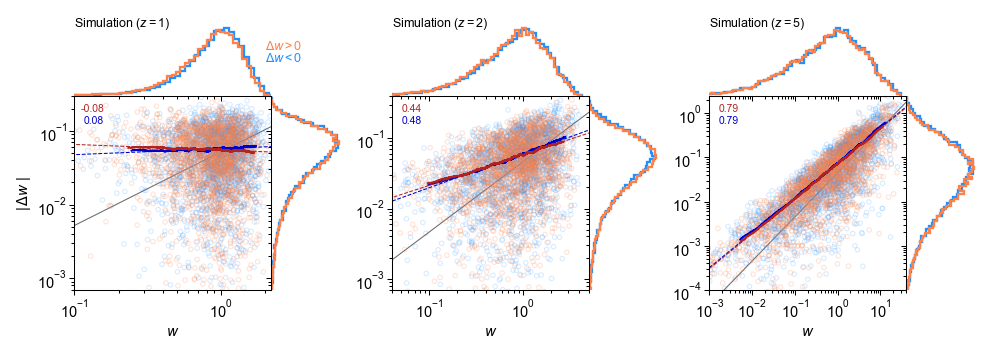

In [34]:
# select data sets
data_sets = [sim_k00['z1'][2], sim_k00['z2'][2], sim_k00['z5'][2]]
z_vec = [1, 2, 5]

ylim_vec = [(7e-4, 3e-1), (7e-4, 4e-1), (1e-4, 2.5e0)]
xlim_vec = [(1e-1, 2.2e0), (4e-2, 5e0), (1e-3, 4e1)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16.5*cm, 5.7*cm))
for i_set in range(len(data_sets)):
    ax = axs[i_set]
    data = data_sets[i_set]
    w_n = data['-'][:,0]
    w_p = data['+'][:,0]
    w_all = np.concatenate((w_n, w_p))
    dw_n = np.abs(data['-'][:,1])
    dw_p = data['+'][:,1]
    dw_all = np.concatenate((dw_n, dw_p))

    rng = np.random.default_rng(123)
    choice_n = rng.choice(np.arange(w_n.size, dtype=int), size=np.minimum(w_n.size, 2000), replace=False)
    choice_p = rng.choice(np.arange(w_p.size, dtype=int), size=np.minimum(w_p.size, 2000), replace=False)

    # scatterplot a subset of the data to not overcrowd the plot
    ax.scatter(w_n[choice_n], dw_n[choice_n], facecolor='none', edgecolor='dodgerblue', alpha=0.18, marker='o', s=20*(72./fig.dpi)**2, lw=0.5)
    ax.scatter(w_p[choice_p], dw_p[choice_p], facecolor='none', edgecolor='xkcd:orangish', alpha=0.23, marker='o', s=20*(72./fig.dpi)**2, lw=0.5)

    # sliding averaging window
    n_window = np.maximum(round(w_n.size/20), 10)
    idx_sort = np.argsort(w_n)
    w_sorted = w_n[idx_sort]
    dw_sorted = dw_n[idx_sort]
    dw_filt = uniform_filter1d(dw_sorted, size=n_window, mode='constant', cval=-1e10)
    idx_filt = dw_filt>0
    dw_filt = dw_filt[idx_filt]
    w_filt = w_sorted[idx_filt]
    ax.plot(w_filt, dw_filt, color='mediumblue', marker=',', lw=1)

    # regression
    regr_filt = linregress(np.log10(w_filt), np.log10(dw_filt))
    ax.plot(np.geomspace(1e-3, 1e2, 20), 10**(regr_filt.intercept)*np.geomspace(1e-3, 1e2, 20)**regr_filt.slope, color='mediumblue', ls='--', lw=0.5)
    regr_slope_n = regr_filt.slope
    ax.text(10**(np.log10(xlim_vec[i_set][0])*0.85+np.log10(xlim_vec[i_set][1])*0.15), 10**(np.log10(ylim_vec[i_set][0])*0.1+np.log10(ylim_vec[i_set][1])*0.9), f'{regr_slope_n:1.2f}', color='mediumblue', ha='right', va='top', size=5)

    # sliding averaging window
    n_window = np.maximum(round(w_p.size/20), 10)
    idx_sort = np.argsort(w_p)
    w_sorted = w_p[idx_sort]
    dw_sorted = dw_p[idx_sort]
    dw_filt = uniform_filter1d(dw_sorted, size=n_window, mode='constant', cval=-1e10)
    idx_filt = dw_filt>0
    dw_filt = dw_filt[idx_filt]
    w_filt = w_sorted[idx_filt]
    ax.plot(w_filt, dw_filt, color='firebrick', marker=',', lw=1)

    # regression
    regr_filt = linregress(np.log10(w_filt), np.log10(dw_filt))
    ax.plot(np.geomspace(1e-3, 1e2, 20), 10**(regr_filt.intercept)*np.geomspace(1e-3, 1e2, 20)**regr_filt.slope, color='firebrick', ls='--', lw=0.5)
    regr_slope_p = regr_filt.slope
    ax.text(10**(np.log10(xlim_vec[i_set][0])*0.85+np.log10(xlim_vec[i_set][1])*0.15), 10**(np.log10(ylim_vec[i_set][0])*0.04+np.log10(ylim_vec[i_set][1])*0.96), round(regr_slope_p,2), color='firebrick', ha='right', va='top', size=5)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", 1.2*cm, pad=0., sharex=ax)
    ax_histy = divider.append_axes("right", 1.2*cm, pad=0., sharey=ax)

    ax_histx.spines['left'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histx.set_yticks([])
    ax_histy.set_xticks([])

    # make some labels invisible
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    ax_histx.patch.set_facecolor('none')

    # histogram
    hist_vals, hist_edges = np.histogram(w_n, bins=np.geomspace(w_n.min(), w_n.max(), 80))
    area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
    ax_histx.stairs(hist_vals/area, hist_edges, color='dodgerblue', alpha=1, lw=1.1)
    hist_vals, hist_edges = np.histogram(w_p, bins=np.geomspace(w_p.min(), w_p.max(), 80))
    area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
    ax_histx.stairs(hist_vals/area, hist_edges, color='xkcd:orangish', alpha=1, lw=1.1)

    # historgram
    hist_vals, hist_edges = np.histogram(dw_n, bins=np.geomspace(dw_n.min(), dw_n.max(), 120))
    area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
    ax_histy.stairs(hist_vals/area, hist_edges, orientation='horizontal', color='dodgerblue', alpha=1, lw=1.1)
    hist_vals, hist_edges = np.histogram(dw_p, bins=np.geomspace(dw_p.min(), dw_p.max(), 120))
    area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
    ax_histy.stairs(hist_vals/area, hist_edges, orientation='horizontal', color='xkcd:orangish', alpha=1, lw=1.1)

    # gray line with unit slope
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lstsq_slope, _, _, _ = lstsq(w_all[:,None], dw_all)
    ax.plot(np.geomspace(1e-5*w_all.min(), 1e5*w_all.max(), 20), np.geomspace(1e-5*w_all.min(), 1e5*w_all.max(), 20)*lstsq_slope, color='dimgrey', lw=0.5, ls='-', zorder=-1e6)
    ax.set_xlim(xlim_vec[i_set])
    ax.set_ylim(ylim_vec[i_set])

    # texts
    if i_set==0:
        ax_histx.text(2, 1.6, r'$\Delta \mathit{w} > 0$', size=6, color='xkcd:orangish', ha='left')
        ax_histx.text(2, 1.2, r'$\Delta \mathit{w} < 0$', size=6, color='dodgerblue', ha='left')

    ax.set_title(r'Simulation ($\mathit{z} = $'+f'{z_vec[i_set]})', y=1.4, size=6, loc='left', ha='left', va='top')
    ax.set_xlabel(r'$\mathit{w}$')

axs[0].set_ylabel(r'$| \, \Delta \mathit{w} \, \, |$')

fig.show()

## Plotting $\Delta w$ vs $w$ (experiment)

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1342/1320554895.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


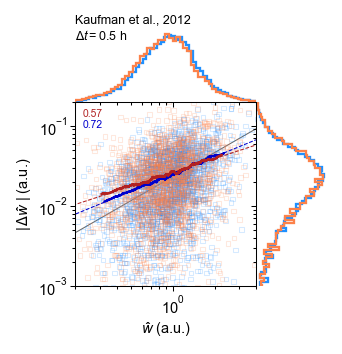

In [36]:
# select data sets
data_sets = [kauf_clean[1]]

hrs_vec = [0.5, 1, 96]
ylim_vec = [(10e-4, 2e-1), (10e-4, 3e-1), (2e-1, 3e2)]
xlim_vec = [(2e-1, 4e0), (2.3e-1, 3.3e0), (4.5e0, 5e2)]

title_vec = ['Kaufman et al., 2012']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5*cm, 5.7*cm))
i_set = 0
data = data_sets[i_set]
w_n = data['-'][:,0]
w_p = data['+'][:,0]
w_all = np.concatenate((w_n, w_p))
dw_n = np.abs(data['-'][:,1])
dw_p = data['+'][:,1]
dw_all = np.concatenate((dw_n, dw_p))

rng = np.random.default_rng(123)
choice_n = rng.choice(np.arange(w_n.size, dtype=int), size=np.minimum(w_n.size, 2000), replace=False)
choice_p = rng.choice(np.arange(w_p.size, dtype=int), size=np.minimum(w_p.size, 2000), replace=False)

# scatterplot a subset of the data to not overcrowd the plot
s_n = ax.scatter(w_n[choice_n], dw_n[choice_n], facecolor='none', edgecolor='dodgerblue', alpha=0.18, marker='s', s=20*(72./fig.dpi)**2, lw=0.5)
s_p = ax.scatter(w_p[choice_p], dw_p[choice_p], facecolor='none', edgecolor='xkcd:orangish', alpha=0.18, marker='s', s=20*(72./fig.dpi)**2, lw=0.5)

# sliding averaging window
n_window = np.maximum(round(w_n.size/20), 10)
idx_sort = np.argsort(w_n)
w_sorted = w_n[idx_sort]
dw_sorted = dw_n[idx_sort]
dw_filt = uniform_filter1d(dw_sorted, size=n_window, mode='constant', cval=-1e10)
idx_filt = dw_filt>0
dw_filt = dw_filt[idx_filt]
w_filt = w_sorted[idx_filt]
ax.plot(w_filt, dw_filt, color='mediumblue', marker=',', lw=1)

# regression
regr_filt = linregress(np.log10(w_filt), np.log10(dw_filt))
ax.plot(np.geomspace(1e-3, 1e2, 20), 10**(regr_filt.intercept)*np.geomspace(1e-3, 1e2, 20)**regr_filt.slope, color='mediumblue', ls='--', lw=0.5)
regr_slope_n = regr_filt.slope
ax.text(10**(np.log10(xlim_vec[i_set][0])*0.85+np.log10(xlim_vec[i_set][1])*0.15), 10**(np.log10(ylim_vec[i_set][0])*0.1+np.log10(ylim_vec[i_set][1])*0.9), f'{regr_slope_n:1.2f}', color='mediumblue', ha='right', va='top', size=5)

# sliding averaging window
n_window = np.maximum(round(w_p.size/20), 10)
idx_sort = np.argsort(w_p)
w_sorted = w_p[idx_sort]
dw_sorted = dw_p[idx_sort]
dw_filt = uniform_filter1d(dw_sorted, size=n_window, mode='constant', cval=-1e10)
idx_filt = dw_filt>0
dw_filt = dw_filt[idx_filt]
w_filt = w_sorted[idx_filt]
ax.plot(w_filt, dw_filt, color='firebrick', marker=',', lw=1)

# regression
regr_filt = linregress(np.log10(w_filt), np.log10(dw_filt))
ax.plot(np.geomspace(1e-3, 1e2, 20), 10**(regr_filt.intercept)*np.geomspace(1e-3, 1e2, 20)**regr_filt.slope, color='firebrick', ls='--', lw=0.5)
regr_slope_p = regr_filt.slope
ax.text(10**(np.log10(xlim_vec[i_set][0])*0.85+np.log10(xlim_vec[i_set][1])*0.15), 10**(np.log10(ylim_vec[i_set][0])*0.04+np.log10(ylim_vec[i_set][1])*0.96), round(regr_slope_p,2), color='firebrick', ha='right', va='top', size=5)

# layout settings
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", size=1.2*cm, pad=0., sharex=ax)
ax_histy = divider.append_axes("right", size=1.2*cm, pad=0., sharey=ax)

ax_histx.spines['left'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histx.set_yticks([])
ax_histy.set_xticks([])

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)
ax_histx.patch.set_facecolor('none')

# histogram
hist_vals, hist_edges = np.histogram(w_n, bins=np.geomspace(w_n.min(), w_n.max(), 60))
area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
h_n = ax_histx.stairs(hist_vals/area, hist_edges, color='dodgerblue', alpha=1, lw=1.1)
hist_vals, hist_edges = np.histogram(w_p, bins=np.geomspace(w_p.min(), w_p.max(), 60))
area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
h_p = ax_histx.stairs(hist_vals/area, hist_edges, color='xkcd:orangish', alpha=1, lw=1.1)

# histogram
hist_vals, hist_edges = np.histogram(dw_n, bins=np.geomspace(dw_n.min(), dw_n.max(), 80))
area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
ax_histy.stairs(hist_vals/area, hist_edges, orientation='horizontal', color='dodgerblue', alpha=1, lw=1.1)
hist_vals, hist_edges = np.histogram(dw_p, bins=np.geomspace(dw_p.min(), dw_p.max(), 80))
area = np.dot(hist_vals, np.diff(np.log10(hist_edges)))
ax_histy.stairs(hist_vals/area, hist_edges, orientation='horizontal', color='xkcd:orangish', alpha=1, lw=1.1)

# gray line with unit slope
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lstsq_slope, _, _, _ = lstsq(w_all[:,None], dw_all)
ax.plot(np.geomspace(1e-5*w_all.min(), 1e5*w_all.max(), 20), np.geomspace(1e-5*w_all.min(), 1e5*w_all.max(), 20)*lstsq_slope, color='dimgrey', lw=0.5, ls='-', zorder=-1e6)
ax.set_xlim(xlim_vec[i_set])
ax.set_ylim(ylim_vec[i_set])

# texts
title_text = ax.set_title(title_vec[i_set]+'\n'+r'$\Delta \mathit{t} =$'+f'{hrs_vec[i_set]} h', y=1.45, size=6, ha='left', va='top', loc='left')
ax.set_xlabel(r'$\mathit{\hat{w}}$ (a.u.)')
ax.set_ylabel(r'$| \, \Delta \mathit{\hat{w}} \,\, |$ (a.u.)')

fig.show()

## Plotting the CV of the weight norms

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1342/4144332971.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


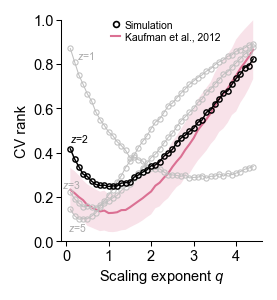

In [6]:
# colors
greens = plt.cm.tab20c(np.array([11,10,9,8]))
purple1 = np.array(mcolors.to_rgba('palevioletred'))
purples = [purple1+(1-purple1)*0.7, purple1]

# select data sets
sim_silent = [sim_k00['z1']['cv'], sim_k00['z2']['cv'], sim_k00['z3']['cv'],
              sim_k00['z5']['cv']]

fig = plt.figure(figsize=(4.4*cm, 4.8*cm))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i_set in range(len(sim_silent)):
    data = sim_silent[i_set]
    norms = data[:,0]
    z_vec = 2/norms
    cv_mean = data[:,1].copy()
    cv_std = data[:,2].copy()
    # cv_std /= (cv_mean.max() - cv_mean.min())
    # cv_mean = (cv_mean - cv_mean.min())/(cv_mean.max() - cv_mean.min())
    z = sim_k00['z'][i_set]
    a = 1 if z==2 else 0.5
    c = 'k' if z==2 else 'silver'
    zord = 100-i_set if z==2 or z==3 else 50-i_set
    lw = 0.7 if z==2 else 0.5
    ax.plot(norms, cv_mean, color=c, mfc='none', marker='o', mew=lw, lw=lw, markersize=2.5, zorder=zord)

# label all simulation lines
#ax.text(sim_k00['z1']['cv'][-1,0]+0.06, sim_k00['z1']['cv'][-1,1]-0.05, va='center', ha='right', s=r'$\mathit{z}\!=\!1$', fontsize=5, color='darkgrey', zorder=50,
#        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
#ax.text(sim_k00['z2']['cv'][-1,0]+0.06, sim_k00['z2']['cv'][-1,1]-0.1, va='center', ha='right', s=r'$\mathit{z}\!=\!2$', fontsize=5, color='k', zorder=70,
#        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
#ax.text(sim_k00['z3']['cv'][0,0]-0.06, sim_k00['z3']['cv'][0,1]-0.08, va='center', ha='left', s=r'$\mathit{z}\!=\!3$', fontsize=5, color='darkgrey', zorder=60,
#        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
#ax.text(sim_k00['z5']['cv'][0,0]-0.06, sim_k00['z5']['cv'][0,1]-0.07, va='center', ha='left', s=r'$\mathit{z}\!=\!5$', fontsize=5, color='darkgrey', zorder=52,
#        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))

data = kauf_clean['cv']
norms = data[:,0]
z_vec = 2/norms
cv_mean = data[:,1].copy()
cv_std = data[:,2].copy()
# cv_std /= (cv_mean.max() - cv_mean.min())
# cv_mean = (cv_mean - cv_mean.min())/(cv_mean.max() - cv_mean.min())
a = 1 if i_set==1 else 0.3
lw = 1 #if i_set==1 else 0.
ax.fill_between(norms, y1=cv_mean-cv_std, y2=cv_mean+cv_std, color=purples[0], ec='none', fc=purple1+(1-purple1)*0.8, zorder=i_set-1)
ax.plot(norms, cv_mean, color=purple1, lw=1, zorder=i_set)

# label all simulation lines
ax.text(sim_k00['z1']['cv'][0,0]+0.15, sim_k00['z1']['cv'][0,1]-0.03, va='center', ha='left', s=r'$\it z\!=\!1$', fontsize=5, color='darkgrey', zorder=50,
        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
ax.text(sim_k00['z2']['cv'][0,0]+0.0, sim_k00['z2']['cv'][0,1]+0.05, va='center', ha='left', s=r'$\it z\!=\!2$', fontsize=5, color='k', zorder=70,
        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
ax.text(sim_k00['z3']['cv'][0,0]-0.2, sim_k00['z3']['cv'][0,1]+0.04, va='center', ha='left', s=r'$\it z\!=\!3$', fontsize=5, color='darkgrey', zorder=60,
        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))
ax.text(sim_k00['z5']['cv'][0,0]-0.06, sim_k00['z5']['cv'][0,1]-0.08, va='center', ha='left', s=r'$\it z\!=\!5$', fontsize=5, color='darkgrey', zorder=52,
        bbox=dict(boxstyle='square,pad=0.', fc='none', ec='none'))

# legend
line_theory = mlines.Line2D([], [], color='k', linestyle='none', lw=1, marker='o', markersize=2.8, mfc='none', mew=0.8)
line_data_raw = mlines.Line2D([], [], color=purples[1], linestyle='-', lw=1)
line_data_smooth = mlines.Line2D([], [], color=purples[0], linestyle='-', lw=1)

leg = ax.legend([line_theory, line_data_raw], ['Simulation', 'Kaufman et al., 2012'],
                loc=(0.25, 0.9), fontsize=5, frameon=False, labelspacing=0.2, handletextpad=.5, handlelength=0.8, borderpad=0, borderaxespad=0.)

# axis settings
#ax.set_xlim([0.0, 4.5])
ax.set_xticks(np.arange(0.0, 4.5, 1))
#ax.set_xscale('log')
ax.set_ylim([0, 1])
#ax.set_yticks([0, 1])
ax.set_ylabel(r'CV rank')
ax.set_xlabel(r'Norm exponent $\mathit{q}$')

fig.show()

#fig.savefig('./fig4_cv_REVISED-DENSE.svg', dpi=300, bbox_inches='tight', pad_inches=0.02*cm)

## $R^2$-values

In [8]:
sim_silent = [sim_k00['z1']['cv'], sim_k00['z2']['cv'], sim_k00['z3']['cv'],
              sim_k00['z4']['cv'], sim_k00['z5']['cv']]

rsquared = np.zeros(5)
for i_z in range(5):
    rss = np.sum( (kauf_clean['cv_all'] - sim_silent[i_z][:,1:2])**2 )
    tss = np.sum( (kauf_clean['cv_all'] - kauf_clean['cv_all'].mean())**2 )
    rsquared[i_z] = 1 - rss/tss

print('R-squared')
for i_z in range(5):
    print(f'z={i_z+1}:', rsquared[i_z])

R-squared
z=1: -0.925451461833124
z=2: 0.6674790097288752
z=3: 0.6415755225468434
z=4: 0.4468258212068501
z=5: 0.24989166610109503


## Illustrating the bootstrap procedure

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1342/3102676348.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


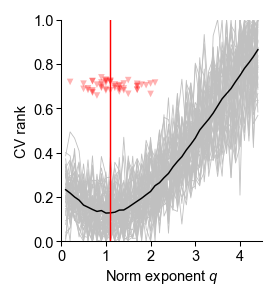

In [22]:
# colors
greens = plt.cm.tab20c(np.array([11,10,9,8]))
purple1 = np.array(mcolors.to_rgba('palevioletred'))
purples = [purple1+(1-purple1)*0.7, purple1]

fig = plt.figure(figsize=(4.4*cm, 4.8*cm))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i_sample in range(20,70):
    cv_vec = kauf_clean['cv_all'][:,i_sample]
    norms = kauf_clean['cv'][:,0]
    #ax.axvline(norms[cv_vec.argmin(axis=0)], color='r', alpha=0.1, lw=0.5)
    ax.plot(norms, cv_vec, color='silver', lw=0.4)

ax.scatter(norms[kauf_clean['cv_all'].argmin(axis=0)][20:70], [0.7+np.random.normal(size=50)*0.02], marker='v',edgecolor='none', facecolor='r', alpha=0.3, s=10)
ax.axvline(kauf_clean['qmin'][0],  c='r', zorder=999, lw=0.7)
ax.plot(norms, kauf_clean['cv_all'].mean(axis=1), color='k', lw=0.7)

ax.set_xlim([0.0, 4.5])
ax.set_xticks(np.arange(0., 4.5, 1))
ax.set_ylim([0, 1])
#ax.set_yticks([0, 1])
ax.set_ylabel(r'CV rank')
ax.set_xlabel(r'Norm exponent $\mathit{q}$')

fig.show()

#fig.savefig('./fig6_cv_REVISED-DENSE-BOOT.pdf', dpi=300, bbox_inches='tight', pad_inches=0.02*cm)

## Plotting the argmin of the CV of the weight norms

q_min: 1.0854000000000001 (0.4301474630867885)


/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1342/983666271.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


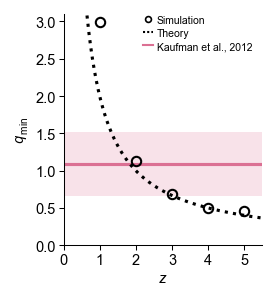

In [26]:
sim_silent = [sim_k00['z1']['qmin'], sim_k00['z2']['qmin'], sim_k00['z3']['qmin'],
              sim_k00['z4']['qmin'], sim_k00['z5']['qmin']]

fig = plt.figure(figsize=(4.4*cm, 4.8*cm))
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

z_vec = np.arange(0.5, 5.5, 0.01)
ax.plot(z_vec, 2/z_vec, color='k', ls=':')

for i_z in range(len(sim_silent)):
    data = sim_silent[i_z]
    z = i_z+1 
    # c = 'dimgray' if z==2 else 'gainsboro'
    # ax.axhline(y=2/z, color=c, ls=':')
    ax.plot([z], data[0], color='k', mfc='none', marker='o', mew=1., markersize=4.5)

ax.axhspan(ymin=kauf_clean['qmin'][0]-kauf_clean['qmin'][1],
           ymax=kauf_clean['qmin'][0]+kauf_clean['qmin'][1], ec='none', fc=purple1+(1-purple1)*0.8, zorder=-100)
ax.axhline(y=kauf_clean['qmin'][0], color=purple1, zorder=-99)

line_sim = mlines.Line2D([], [], color='k', linestyle='none', marker='o', markersize=2.8, mfc='none', mew=0.8)
line_theory = mlines.Line2D([], [], color='k', linestyle=(0,(1.,1)), lw=1)
line_data = mlines.Line2D([], [], color=purple1, linestyle='-', lw=1)

leg = ax.legend([line_sim, line_theory, line_data], ['Simulation', 'Theory', 'Kaufman et al., 2012'],
                loc=(0.4, 0.84), fontsize=5., frameon=False, labelspacing=0.3, handletextpad=.3, handlelength=1, borderpad=0, borderaxespad=0.)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim([0.0, 5.5])
# ax.set_yticks(np.linspace(0.2, 2.2, 6))
ax.set_ylim([0.0, 3.1])

ax.set_xlabel(r'$\mathit{z}$')
ax.set_ylabel(r'$\mathit{q}_{\,min}$')

fig.show()

print(f'q_min: {kauf_clean['qmin'][0]} ({kauf_clean['qmin'][1]})')

#fig.savefig('./fig4_qmin_REVISED-DENSE.pdf', dpi=300, bbox_inches='tight', pad_inches=0.02*cm)